# [E-12] GAN Fashion_model

# 목차

STEP 0. 작업환경 구성하기

STEP 1. 데이터 전처리

STEP 2. 생성자 모델 구현하기

STEP 3. 판별자 모델 구현하기

STEP 4. 손실함수와 최적화 함수 구현하기

STEP 5. 훈련과정 상세 기능 구현하기

STEP 6. 학습 과정 진행하기

STEP 7. 학습 과정 개선하기

# 루브릭

1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
	오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
    

2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
	gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.


3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
	제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

# Gan 구조

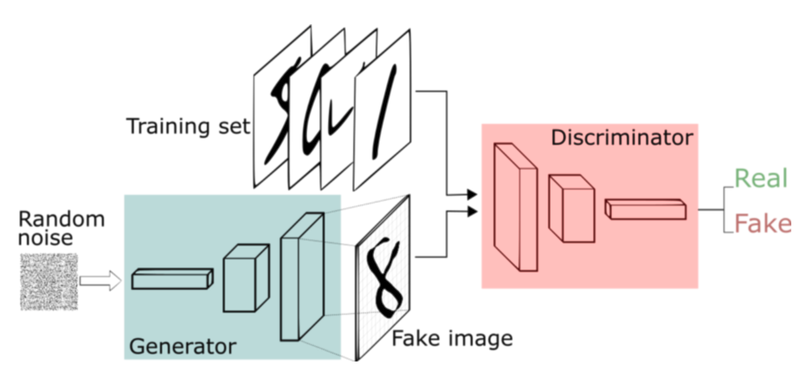

gan은 생성자와 판별자가 있다. 

먼저 생성자는 random한 노이즈 벡터를 입력값으로 받는다.

입력된 벡터를 생성자가 신경망에서의 연산을 통해 이미지 형상의 백터를 만든다. 

이미지 형상의 벡터는 fake image다.

이후 training set으로 실제 이미지를 입력한다.

실제 이미지와 가짜 이미지를 판별자에 넣고 각 이미지가 진짜인지 가짜인지 숫자로 표현한다.

이때 생성자의 목표는 가짜이미지를 진짜 이미지로 판별받는 것이고 판별자의 목표는 진짜는 진짜로 가짜는 가짜로 정확하게 판별하는 것이다.

# STEP 0. 작업환경 구성하기

In [4]:
import os
import glob
import time
import cv2
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


# STEP 1. 데이터셋 구성하기 ( 데이터 전처리)

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_x.shape

(50000, 32, 32, 3)

In [9]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

In [10]:
# train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


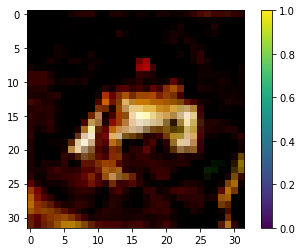

In [11]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

## 오류!

1. plt.imshow(train_x[0].reshape(32, 32), cmap='gray')

위와 같이 reshape하면 사이즈가 맞지 않는다는 오류가 떴다.
* cannot reshape array of size 3072 into shape (32,32)

그래서 -1을 넣어서 자동으로 사이즈를 변환하는 방법을 선택했다. 
해결!! = 이번 예제는 채널이 포함된 예제라 사이즈를 변환할 필요가 없다고 한다!

2. 처음에 cmap을 rgb로 설정하면 오류가 났다.

cmap은 opencv에서는 rgb나 gray로 색상을 지정했어야 했다.
matplobil은 기본값이 컬러라서 cmp을 rgb로 설정하면 오히려 오류가 뜬다...그래서 설정하지 않고 진행했다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

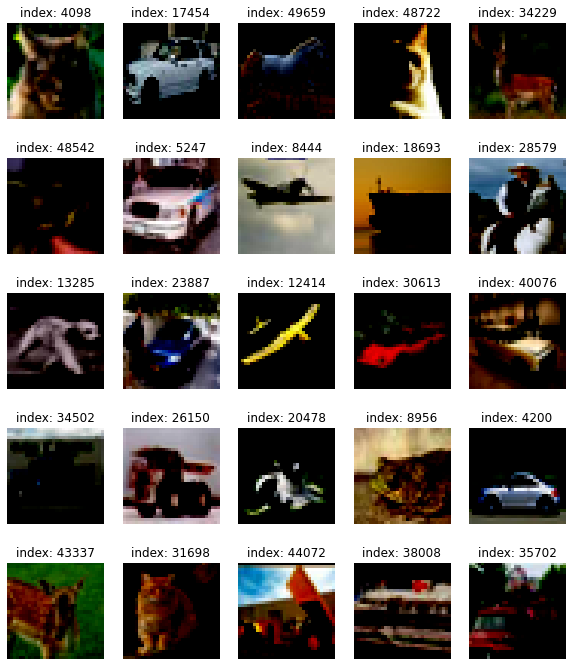

In [12]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000) #랜덤으로 추출
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [17]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128 #모델이 한번에 학습할 양

In [18]:
#train_x를 넘파이형에 넣고 배치사이즈별로 나눠서 buffersize로 잘 섞어서 사용한다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP 2. 생성자 모델 구현하기

gan에는 생성자와 판별자가 있다. 

    (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
    noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
    생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

# 코드 이해하기 

(32,32,3)의 shape를 가졌으므로 8*8*256 이다.

 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나갑니다.

입력값은 8*8*256(16384)개의 노드를 가진 첫번째 dense레이더를 거치고(batch_size, 16384)형상의 벡터가 된다.

두번째는 reshape레이어를 지난다. 다음 레이어에서 CONV연산을 할 수 있도록 1차원을 3차원으로 바꾸는 작업

3,4,5번째 Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다,
8,8,256-16,16,64-32,32,3 순으로 이미지를 키운다.

최종 5번째에서 TANH함수를 쓰는 이유는 -1~1값으로 픽셀값을 정규화한 데이터셋과 동일학 하려고 

In [19]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) #가중치 값을 정규화
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer #이미지 키우기 
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) #-1~1로 정규화했던 데이터셋과 동일하게 만든다.

    return model

In [20]:
generator = make_generator_model()

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

In [21]:
#모델의 입력값 노이즈 벡터
noise = tf.random.normal([1, 100])

In [22]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

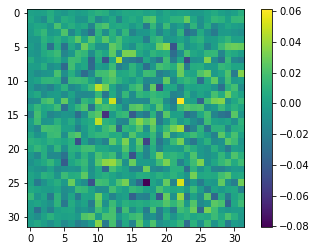

In [23]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# STEP 3. 판별자 모델 구현하기

    (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
    위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

생성자는 CONV2DTranspose층으로 이미지를 키웠지만,

판별자는 conv2D로 이미지 크기를 줄인다. 

마지막에 flatten을 사용해서 3차원을 1차원으로 펴서 8 * 8 * 128 형상의 벡터로 변환한다.

이후 dence 레이어로 1개의 값을 출력한다. 

In [24]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [25]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [26]:
#가짜이미지를 판별자에 입력

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00314444]], dtype=float32)>

# STEP 4. 손실함수와 최적화 함수 구현하기

    생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
    판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
    생성자와 판별자를 최적화하는 optimizer를 정의합니다.


# 손실함수 구현하기

가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지 정량적으로 계산

* 생성자는 가짜이미지와 판별자가 판별한 이미지가 얼만큼 차이가 나는지
* 판별자는 진짜이미지와 판별자의 판별이 얼마나 차이가 나는지 

#### 생성자의 목표는 판별자가 가짜이미지를 진짜(1)로 판별하게 하는 것
#### 판별자의 목표는 진짜는 진짜(1)로 가짜는 가짜(0)로 판별하는 것 

단, 생성자는 값을 -1~1값으로 정규화하여 출력하는데 판별자는 마지막 layer에 정규화를 위한 simoide or tanh값이 없다. 
하지만 손실함수의 binarycross entropy 클래스는 인풋값을 0-1사이 확률값이라고 자동으로 가정함. 

from logits = True로 설정해야 binaryCrossEntropy에 입력된 값을 시그모이드로 0-1사이로 정규화할 수 있다. 

* cross entropy를 사용해서 loss 계산

fake output: 생성자의 가짜이미지를 판별자가 판별한 값

real_output: Train image(진짜 이미지)를 판별자가 판별한 값

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
#생성자의 loss는 가짜이미지가 1에 가까워지는 것이 목표
# fake output이 1에 가까울수록 작은 값을 갖는다. 

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
def discriminator_loss(real_output, fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

# 정확도 구현하기 
정확도가 1이 나오면 생성자의 가짜이미지가 가짜티가 나서 진짜와 가짜를 판별하기 쉬운 상태를 의미함!생성자가 판별자를 잘 못속이고 있다는 것!

둘다 0.5가 나와야 이상적!

In [30]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 함수이해하기
1. tf.math.greater_equal(real_output, tf.constant([0.5]): 진짜이미지를 판별한 값의 각 원소가 0.5이상인지 true, false로 판별
2. tf.cast( 1, tf.float32) : 1번의 결과가 true면 1.0 false면 0으로 바꾼다.
3. tf.reduce_mean(2): 2번 결과의 평균을 내서 정확도를 계산

# 최적화 함수(optimizer)
* adam 최적화 기법

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [32]:
#생성자의 샘플 확인하기 
noise_dim = 100
generate_sample = 16

seed = tf.random.normal([generate_sample,noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 5. 훈련과정 상세 기능 구현하기

    1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
    16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
    훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
    training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.


In [33]:
#train_step 함수
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

# 코드 이해하기
(1) 진짜 이미지를 입력으로 받음

(2) 생성자가 가짜 이미지를 생성하기 위해 입력하는 noise를 받고 진짜 이미지와 같은 크기로 생성함

(3) 가중치 갱신을 위한 gradient를 자동으로 계산하기 위함

(4) noise를 입력받고 generated image(가짜 이미지) 만든다.

(5) 판별자가 진짜이미지와 가짜이미지를 입력으로 받고 판별한 결과를 출력

(6) 각각 output값으로 손실을 계산

(7) 각각 output값으로 정확도 계산

(8) gen tape와 disc_tape로 가중치를 자동계산

(9) 가중치를 최적화에 입력해서 가중치를 계산

(10) 한 스템에 계산된 손실과 정확도를 리턴한다. 

In [34]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('{}/aiffel/aiffel_exp_data/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/aiffel_exp_data/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [36]:
# #중간에 생성자와 판별자가 학습한 모델가중치를 저장한다
checkpoint_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

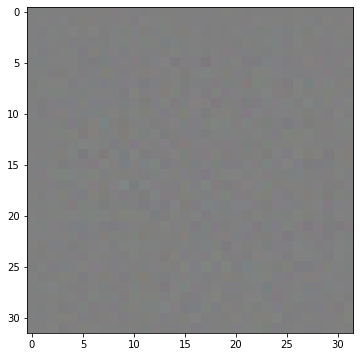

In [37]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# STEP 6. 학습 과정 진행하기

    위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
    학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
    학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.


In [44]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset): #모델학습
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True) #loss와 accuracy를 시각화
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [142]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

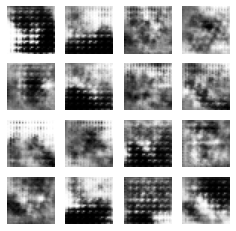

Time for training : 526 sec


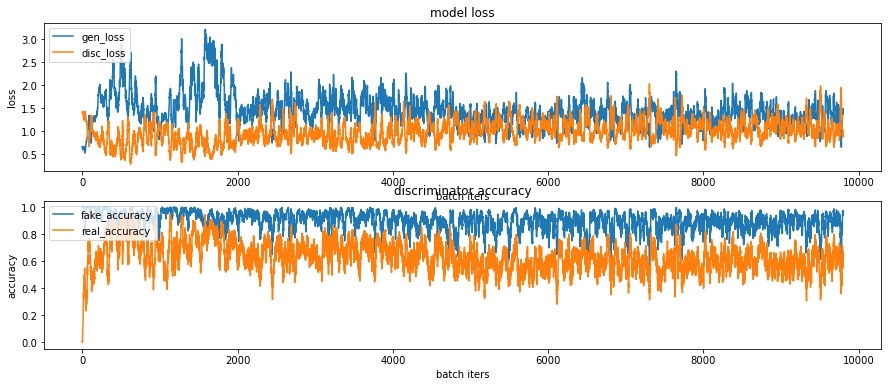

CPU times: user 8min 51s, sys: 11.9 s, total: 9min 3s
Wall time: 8min 47s


In [143]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

# 학습과정 시각화하기

In [144]:
anim_file = os.getenv('HOME')+'/aiffel/aiffel_exp_data/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/aiffel_exp_data/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/aiffel_exp_data/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel-dj54 aiffel-dj54 1338530  3월  1 15:53 /home/aiffel-dj54/aiffel/aiffel_exp_data/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


# STEP 7. (optional) GAN 훈련 과정 개선하기

    STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
    모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

### 문제점

1. 정확도 부분 fake accuracy 가 1일수록 가짜를 가짜로 잘 분별하다는 의미인데 generator는 가짜를 진짜로 분별하도록 해야함!
그래서 fake accuarcy와 real accuracy가 둘다 0.5가 나오는 것이 좋다. 

2. loss부분 gen loss의 목표는 1이 되는 것, disc_loss의 목표는 진짜는 1 가짜는 0으로 판별해서 결국 1이 되는것이다.
현재는 초반에 변동이 크고 뒷부분으로 갈수록 1에 가까워지지만 좀 더 개선할 필요가 있다.

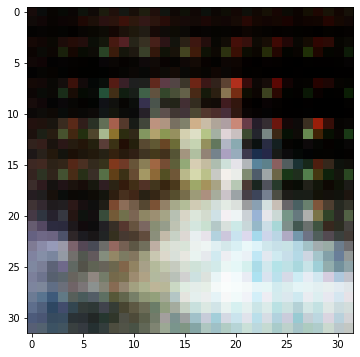

In [146]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [147]:
save_every = 5
EPOCHS = 150

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

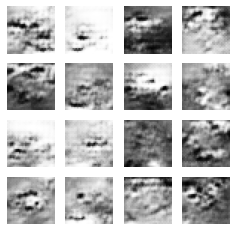

Time for training : 1693 sec


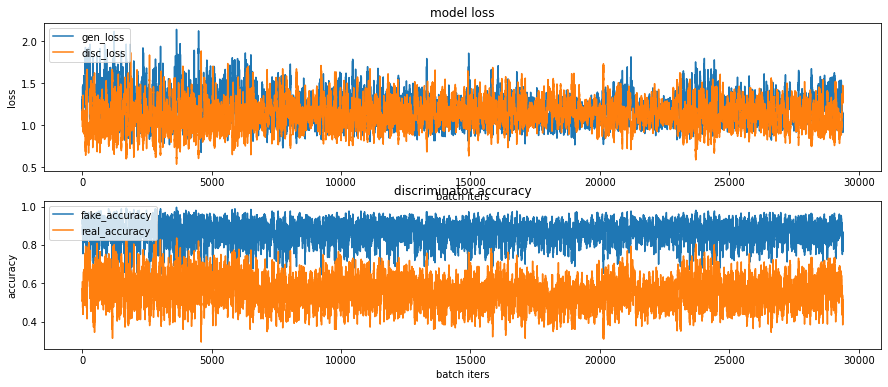

CPU times: user 28min 37s, sys: 32.2 s, total: 29min 10s
Wall time: 28min 15s


In [148]:
%%time
train(train_dataset, EPOCHS, save_every)

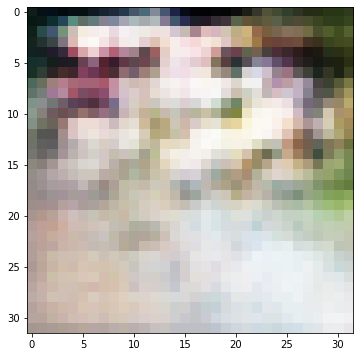

In [149]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [150]:
save_every = 5
EPOCHS = 250

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

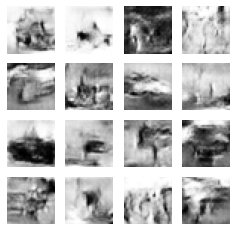

Time for training : 2766 sec


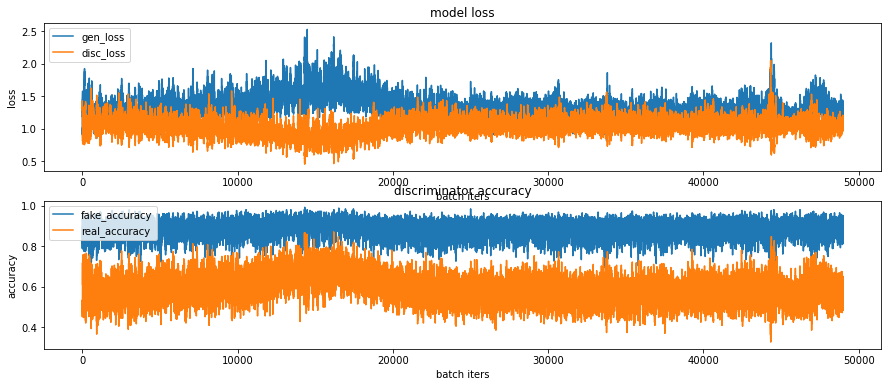

CPU times: user 46min 45s, sys: 53.1 s, total: 47min 38s
Wall time: 46min 8s


In [151]:
%%time
train(train_dataset, EPOCHS, save_every)

# 
epoch 50일때보다 150일때 손실은 더 개선됐고 real accuracy도 0.5에 가깝게 됐지만 여전히 fake accuracy는 1에 머물렀다.
250일때도 fake accuracy는 1에 머물렀다. 

세번째 시도는 350 epoch!!

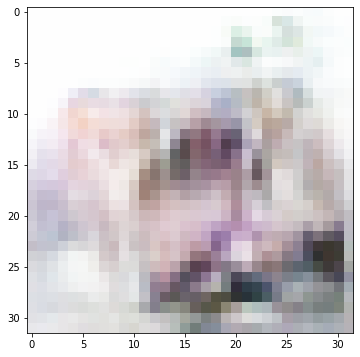

In [152]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [155]:
save_every = 10
EPOCHS = 350

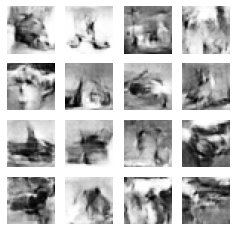

Time for training : 3887 sec


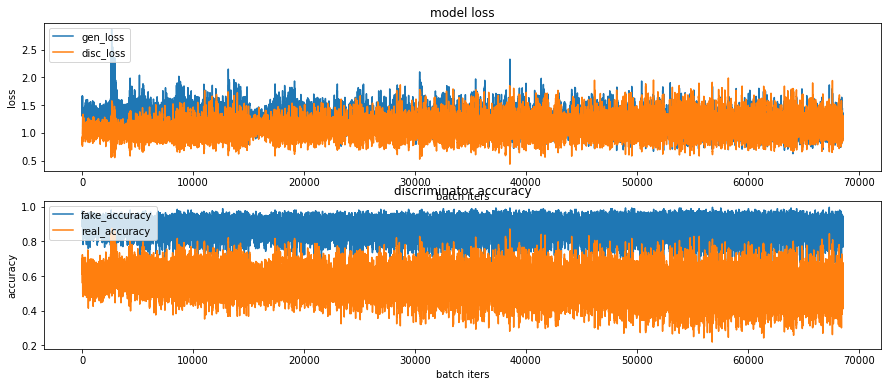

CPU times: user 1h 5min 38s, sys: 1min 13s, total: 1h 6min 52s
Wall time: 1h 4min 50s


In [156]:
%%time
train(train_dataset, EPOCHS, save_every)

In [158]:
anim_file = os.getenv('HOME')+'/aiffel/aiffel_exp_data/dcgan_newimage/fashion/fashion_mnist_dcgan2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/aiffel_exp_data/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/aiffel_exp_data/dcgan_newimage/fashion/fashion_mnist_dcgan2.gif

-rw-r--r-- 1 aiffel-dj54 aiffel-dj54 3487445  3월  1 20:37 /home/aiffel-dj54/aiffel/aiffel_exp_data/dcgan_newimage/fashion/fashion_mnist_dcgan2.gif


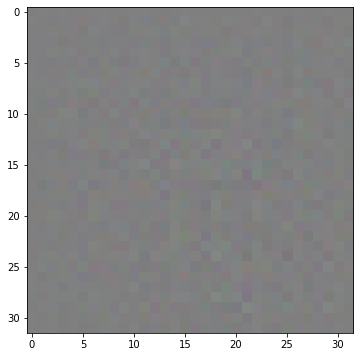

In [45]:
# 배치사이즈 128로 수정 후 다시 
checkpoint_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [46]:
save_every = 10
EPOCHS = 350

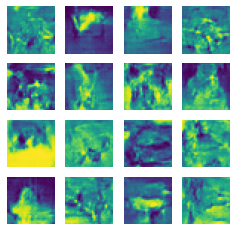

Time for training : 5757 sec


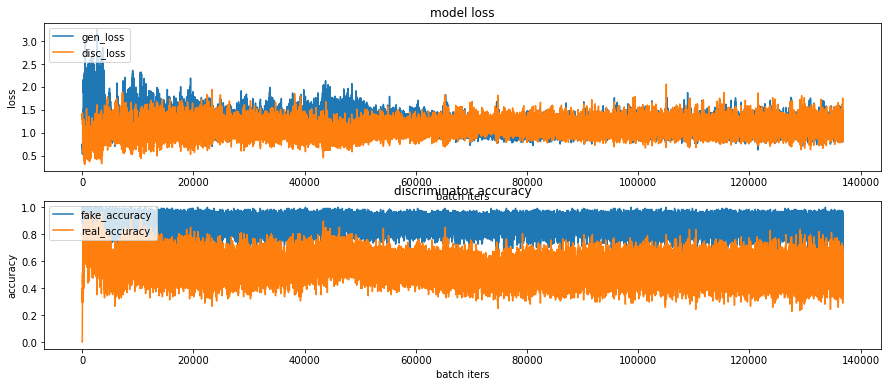

CPU times: user 58min 2s, sys: 1min 51s, total: 59min 53s
Wall time: 1h 36min 2s


In [47]:
%%time
train(train_dataset, EPOCHS, save_every)

# 회고
1. epoch를 350까지 돌려도 fake accuracy가 0.5로 떨어지지 않는다...loss는 둘다 얼추 1로 나온거 같은데 정확도 부분이 아쉽다.
2. 무에서 유를 창조한다는 개념이 흥미로웠다. AI는 생각보다 더 빠르게 발전했고 이미 많은 일을 할 수 있구나 알게된 부분이었다.
3. 창의력은 사람의 영역이라고 생각했는데 생성모델을 보면서 앞으로 창의적인 일은 AI가 사람보다 뛰어날것 같다고 생각했다. 
한 사람이 학습하고 사고할 수 있는 부분은 한정적이지만, AI는 학습 양이 비교할 수 없을 만큼 많기에 새로운 시각으로 적용도 빠르구나 생각했다. AI가 사람을 능가할 날이 멀지 않았나 싶기도 하고 한편으로는 AI도 결국 사람이 만든 것이기에 이 기술을 잘 다룬다는 의미는 AI가 흡수하고 사용하는 지식이 곧 내 지식이 된다는 것 같기도 하다. 